In [1]:
import numpy as np
import pycbc.filter
import pycbc.vetoes
import matplotlib.pyplot as plt
from scipy import signal
from pycbc.psd import welch
from pycbc.types import TimeSeries, FrequencySeries
%matplotlib inline

ModuleNotFoundError: No module named 'pycbc'

(0.0, 0.01239679690392052)


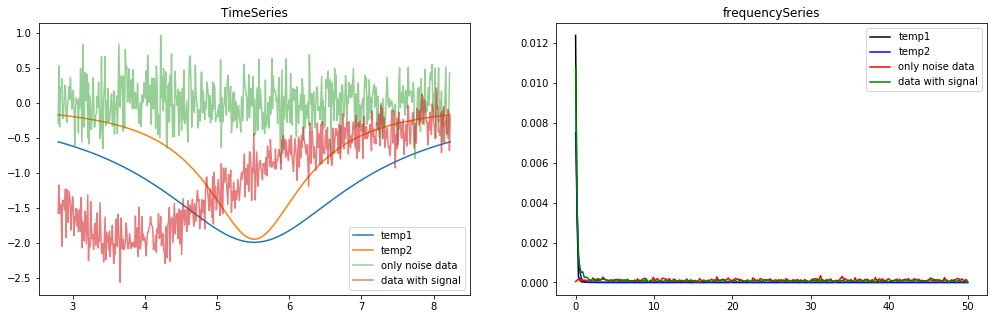

In [2]:
# delta_t = 1.0 / 4096
# tsamples = int(16 / delta_t)
# nn = 4096
delta_t = 0.01
Fs = 1 / delta_t
tsamples = 128 * 4
tmin = 2.8
tmax = 8.23
tsamples = int((tmax - tmin)/delta_t) + 1
times = (np.arange(tsamples) * delta_t) + tmin

def eval(U0, t0, tE, fs, times):
    """Evaluate microlens event at given time array, return magnitude difference"""
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    return dm
dwindow = signal.tukey(tsamples, alpha=1./8)
t0 = (max(times) + min(times))/2
tE = 0.8 
U0 = 1.3 
fs = 16.9
val = eval(U0, tmin + 1, tE, fs, times)
np.random.seed(126)
data = val + np.random.normal(0, 0.2, tsamples)

val = eval(U0, t0, tE, fs, times)
tE = 0.5
U0 = 1.0
fs = 10
val2 = eval(U0, t0, tE, fs, times)

val = TimeSeries(val, delta_t=delta_t)
val2 = TimeSeries(val2, delta_t=delta_t)
np.random.seed(2345)
data0 = TimeSeries(np.random.normal(0, 0.3, tsamples), delta_t=delta_t)
data = TimeSeries(data, delta_t=delta_t)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 5))
ax1.plot(times, val, label="temp1")
ax1.plot(times, val2, label="temp2")
ax1.plot(times, data0, alpha=0.5, label="only noise data")
ax1.plot(times, data, alpha=0.6, label="data with signal")
ax1.legend()
ax1.set_title("TimeSeries")
htilde1 = val.to_frequencyseries()
htilde2 = val2.to_frequencyseries()
stilde = data.to_frequencyseries()
stilde0 = data0.to_frequencyseries()
freqs = stilde.sample_frequencies
ax2.plot(freqs, abs(htilde1)/tsamples, 'k', label="temp1")
ax2.plot(freqs, abs(htilde2)/tsamples, 'b', label="temp2")
ax2.plot(freqs, abs(stilde0)/tsamples, 'r', label="only noise data")
ax2.plot(freqs, abs(stilde)/tsamples, 'g', label="data with signal")
ax2.legend()
ax2.set_title("frequencySeries")
print(freqs[0], abs(htilde1[0])/tsamples)


100.0
273
273
(0.1838235294117647, 0.1838235294117647, 0.1838235294117647)
0.00013989921475243109


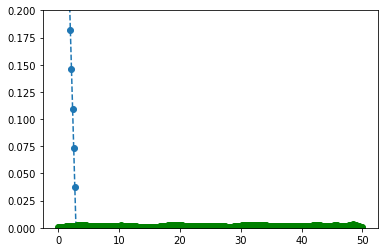

In [3]:
print(Fs)
nn = tsamples//8
psd = welch(data, seg_len=nn, seg_stride=nn//2)
psd0 = welch(data0, seg_len=nn, seg_stride=nn//2)
psd = np.interp(stilde.sample_frequencies, psd.sample_frequencies, psd.data)
psd0 = np.interp(stilde.sample_frequencies, psd0.sample_frequencies, psd0.data)
psd = FrequencySeries(psd, delta_f=stilde.delta_f)
psd0 = FrequencySeries(psd0, delta_f=stilde.delta_f)

plt.plot(psd.sample_frequencies, psd, 'o--')
plt.plot(psd0.sample_frequencies, psd0, 'go--')
plt.ylim([0, 0.2])
print(len(psd.sample_frequencies))
print(len(stilde.sample_frequencies))
print(psd.delta_f, stilde.delta_f, psd0.delta_f)
print(min(psd))

creating /tmp/weave-pancho-OOMguu/python27_intermediate/compiler_db7c1de5cc7c396407366e089d8b0d01


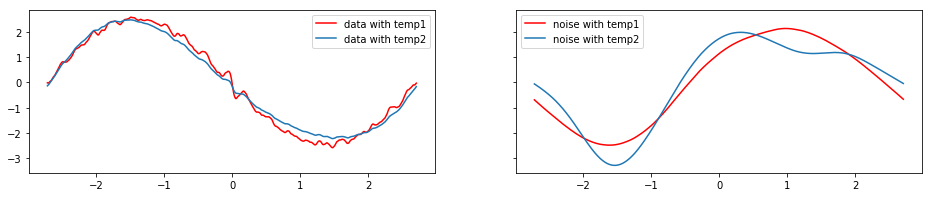

In [4]:
snr = pycbc.filter.matched_filter(htilde1, stilde, psd=psd)
snr2 = pycbc.filter.matched_filter(htilde2, stilde, psd=psd)

snr0 = pycbc.filter.matched_filter(htilde1, stilde0, psd=psd0)
snr02 = pycbc.filter.matched_filter(htilde2, stilde0, psd=psd0)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3), sharey=True)
ax1.plot(times - times[tsamples//2], (np.roll(snr, tsamples//2)).real, 'r', label="data with temp1")
ax1.plot(times - times[tsamples//2], (np.roll(snr2, tsamples//2)).real, label="data with temp2")
ax1.legend()

ax2.plot(times - times[tsamples//2], (np.roll(snr0, tsamples//2)).real, 'r', label="noise with temp1")
ax2.plot(times - times[tsamples//2], (np.roll(snr02, tsamples//2)).real, label="noise with temp2")
ax2.legend()

In [6]:
times[1] - times[0]

2

In [7]:
max(snr)

(14.82410930153188+2.2315535673837625j)

In [5]:
# num_bins = int(tsamples*delta_t)
num_bins = 16
chisq = pycbc.vetoes.power_chisq(val, data, num_bins, psd)
# convert to a reduced chisq
chisq /= (num_bins * 2) - 2

chisq2 = pycbc.vetoes.power_chisq(val2, data, num_bins, psd)
# convert to a reduced chisq
chisq2 /= (num_bins * 2) - 2

chisq0 = pycbc.vetoes.power_chisq(val, data0, num_bins, psd0)
# convert to a reduced chisq
chisq0 /= (num_bins * 2) - 2

chisq02 = pycbc.vetoes.power_chisq(val2, data0, num_bins, psd0)
# convert to a reduced chisq
chisq02 /= (num_bins * 2) - 2

ValueError: initial_array must contain at least one sample.

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
ax1.plot(times - times[tsamples//2], np.roll(chisq, tsamples//2), 'r')
ax1.plot(times - times[tsamples//2], np.roll(chisq2, tsamples//2), 'b')

ax2.plot(times - times[tsamples//2], np.roll(chisq0, tsamples//2), 'r')
ax2.plot(times - times[tsamples//2], np.roll(chisq02, tsamples//2), 'b')


plt.ylabel('$\chi^2_r$')
plt.xlabel('time (s)')

In [ ]:
snr_cpy = snr.copy()
snr2_cpy = snr2.copy()

snr0_cpy = snr0.copy()
snr02_cpy = snr02.copy()

In [ ]:
def weighted_snr(snr, chisq):
    for i in range(len(chisq)):
        if chisq[i] > 1:
            snr[i] /= ((1 + chisq[i]**(3))/2.0)**(1.0/6)
        
    return snr

w_snr = weighted_snr(snr_cpy, chisq)
w_snr2 = weighted_snr(snr2_cpy, chisq2)

w_snr0 = weighted_snr(snr0_cpy, chisq0)
w_snr02 = weighted_snr(snr02_cpy, chisq02)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))

ax1.plot(times - times[tsamples//2], (np.roll(w_snr, tsamples//2)).real, 'r')
ax1.plot(times - times[tsamples//2], (np.roll(w_snr2, tsamples//2)).real)

ax2.plot(times - times[tsamples//2], (np.roll(w_snr0, tsamples//2)).real, 'r')
ax2.plot(times - times[tsamples//2], (np.roll(w_snr02, tsamples//2)).real)